In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

import sys
sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import ASC_datasets
import audio_utils as au

TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
SAMPLE_RATE = 32000

In [139]:
csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv'
df = pd.read_csv(csv)
scenes = df.scene_preds.unique()

In [140]:
at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.1:
            event_list.append(np.array(labels)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
GPU number: 4


In [23]:
# Loop for predicting audio tags for the original audio
audio_tags_org = []

for i, row in df.iterrows():
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    audio_tags_org.append(get_panns_events_list(audio))

In [27]:
df['audio_tags_org'] = audio_tags_org

In [141]:
audioset_ontology_df = pd.read_json('audioset_ontology.json')

def get_event_ids(event_id):
    idx = audioset_ontology_df[audioset_ontology_df['child_ids'].apply(lambda x: event_id in x)]
    if len(idx) > 0:
        return idx['id'].iloc[0]
    else:
        return 'None'
    
def get_immediate_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label

def get_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    while get_event_ids(parent_event_id) != 'None':
        parent_event_id = get_event_ids(parent_event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label


In [170]:
import ast

csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds_withOrgTags.csv'
df = pd.read_csv(csv)
scenes = df['labels'].unique()
df['audio_tags_org'] = df['audio_tags_org'].apply(lambda x: ast.literal_eval(x))

In [171]:
# Counting all the tags in the original audio
all_tags = set()

rearranged_filtered_tags = ['Outside, urban or manmade', 'Inside, public space', 'Wind', 'Recording', 'Ocean', 'Animal',
 'Human sounds', 'Human locomotion', 'Clip-clop', 'Rail transport', 'Vehicle', 'Music',
 'Aircraft', 'Rumble', 'Clickety-clack']

for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        all_tags.add(tag)

In [172]:
# PANNs unique audio tags and counts for each scene
scene_tag_counts = defaultdict(dict)
all_tags = list(all_tags)

for scene in scenes:
    for tag in all_tags:
        scene_tag_counts[scene][tag] = 0

In [173]:
# Counting the tags for each scene
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        scene_tag_counts[row['labels']][tag] += 1
        

In [174]:
# Counting the rearranged filtered tags
scene_filtered_tags_counts = defaultdict(dict)
for scene in scenes:
    for tag in rearranged_filtered_tags:
        scene_filtered_tags_counts[scene][tag] = 0

In [175]:
# Creating a dataframe
scene_tag_counts_df = pd.DataFrame.from_dict(scene_tag_counts)

# Normalizing the counts
for scene in scenes:
    # Here we normalized the counts using the total number of files for each scene
    # This gives us the number of times a tag was predicted against the total number of files for that scene
    # We then divide by the total number of files for that scene
        
        # THis approach worked out for the earlier idea, now the idea is to look at a subset of tags
    total = df['labels'].value_counts()[scene]

    for index in scene_tag_counts_df.index:
        #scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total
        tag = index
        if (scene_tag_counts_df[scene][index])/total > 0.1:
            if index in rearranged_filtered_tags:
                scene_filtered_tags_counts[scene][index] += (scene_tag_counts_df[scene][index])
            else:
                print(index)
                while tag not in rearranged_filtered_tags:
                    tag = get_immediate_parent_class_label(tag)
                scene_filtered_tags_counts[scene][tag] += (scene_tag_counts_df[scene][index])


Train
Car
Hubbub, speech noise, speech babble
Run
Traffic noise, roadway noise
Subway, metro, underground
Railroad car, train wagon
Speech
Train
Car
Field recording
Bus
Motor vehicle (road)
Railroad car, train wagon
Speech
Train
Car
Bus
Fixed-wing aircraft, airplane
Subway, metro, underground
Railroad car, train wagon
Speech
Train
Bus
Subway, metro, underground
Railroad car, train wagon
Train wheels squealing
Speech
Car
Field recording
Fixed-wing aircraft, airplane
Boat, Water vehicle
Duck
Speech
Car
Ship
Field recording
Hubbub, speech noise, speech babble
Wind noise (microphone)
Fixed-wing aircraft, airplane
Traffic noise, roadway noise
Boat, Water vehicle
Waves, surf
Speech
Train
Subway, metro, underground
Railroad car, train wagon
Speech
Train
Car
Hubbub, speech noise, speech babble
Traffic noise, roadway noise
Speech
Car
Truck
Field recording
Bus
Motor vehicle (road)
Traffic noise, roadway noise
Boat, Water vehicle
Speech
Train
Car
Field recording
Bus
Subway, metro, underground
Rai

In [176]:
# Normalizing the filtered tags
scene_filtered_tags_counts_df = pd.DataFrame.from_dict(scene_filtered_tags_counts)

for scene in scenes:
    total = scene_filtered_tags_counts_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    for index in scene_filtered_tags_counts_df.index:
        scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total

/tmp/ipykernel_280467/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06726907630522089' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_280467/2578130740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_280467/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.057624113475177305' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<Axes: >

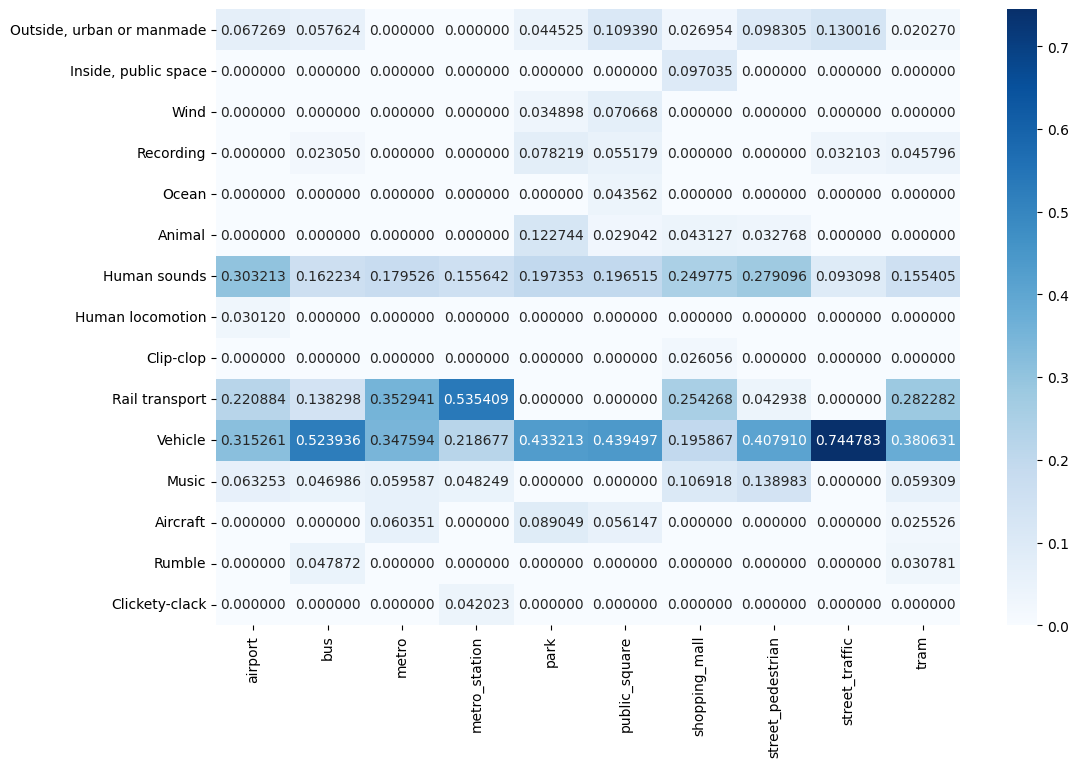

In [177]:
plt.figure(figsize=(12,8))
sns.heatmap(scene_filtered_tags_counts_df, fmt='f', annot=True, cmap='Blues')

In [52]:
thresholded_all_tags = set()

for scene in scenes:
    for tag in all_tags:
        if (scene_tag_counts_df[scene][tag])>0.1:
            thresholded_all_tags.add(tag)

In [53]:
valid_indices = [index for index in thresholded_all_tags if index in scene_tag_counts_df.index]

thresholded_scene_tag_counts_df = pd.DataFrame(columns=scenes, index=valid_indices)

for scene in scenes:
    for tag in valid_indices:
        thresholded_scene_tag_counts_df[scene][tag] = scene_tag_counts_df[scene][tag]

In [54]:
#sns.heatmap(better_df, fmt='f', annot=True, cmap='Blues')
thresholded_scene_tag_counts_df = thresholded_scene_tag_counts_df.apply(pd.to_numeric)


<Axes: >

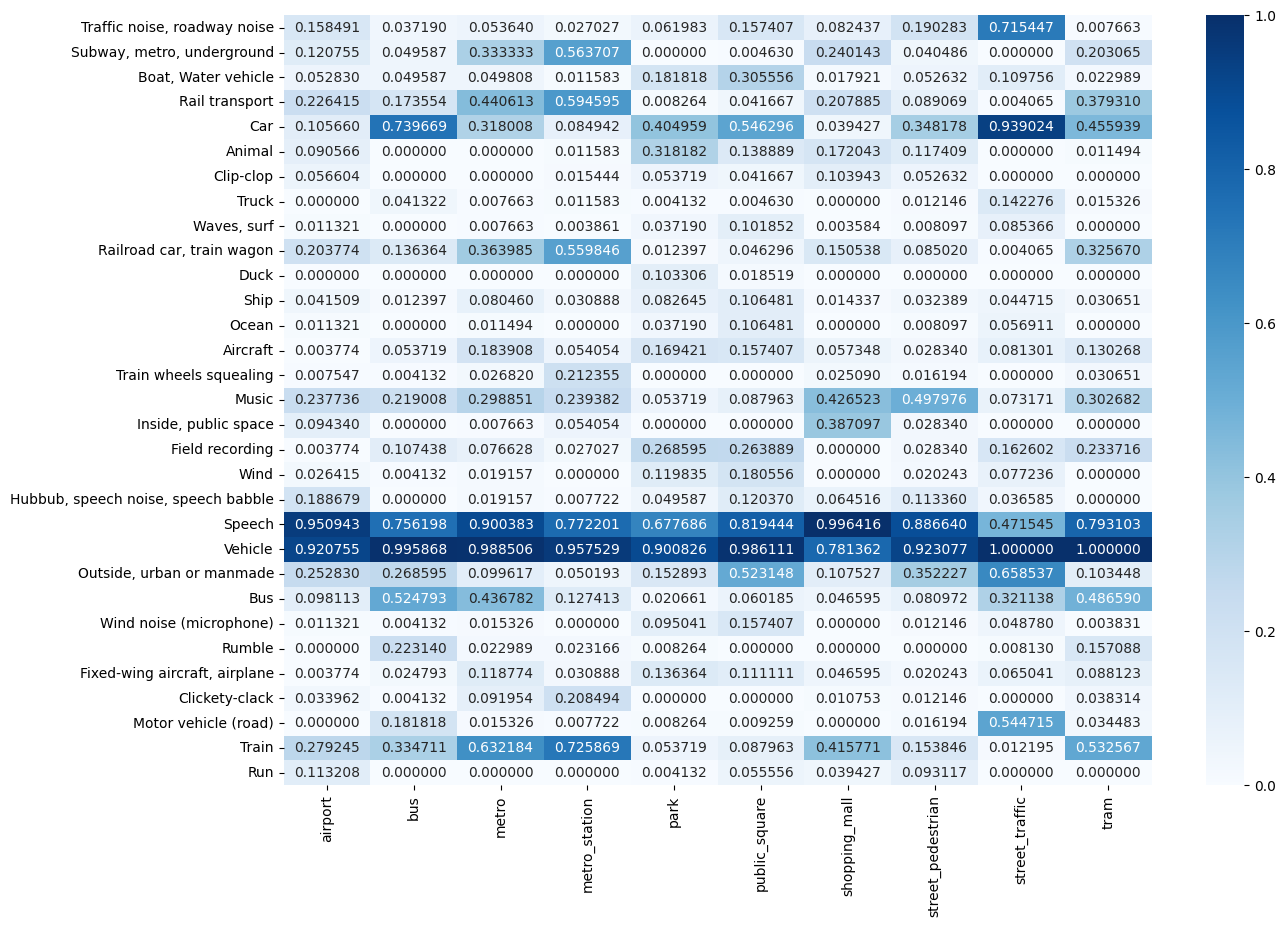

In [77]:
# We have to rethink this plot. We normalised it using the total number of events in all the files,
# Rather we should be normalising the frequency of each tag with the total number of files, which should give us a better representation
# That will give us an idea about the % of times a tag occured in a scene : DONE!!!!!!

'''
we need to filter out the tag labels a little bit so that we can have a better view of the data
For instance, Duck can be considered as Animal label, Subway metro, etc can be considered as Rail Transport, etc. 
Look at the list of tags, and come up with a better list of tags and adjust the dataframe accordingly
'''
plt.figure(figsize=(14,10))
sns.heatmap(thresholded_scene_tag_counts_df, fmt='f', annot=True, cmap='Blues')

In [124]:
'''a = ['Human locomotion', 'Rail transport', 'Vehicle', 'Clickety-clack', 'Aircraft',
 'Rumble', 'Wind', 'Outside, urban or manmade', 'Human sounds', 'Recording', 'Inside, public space',
 'Music', 'Ocean', 'Clip-clop']'''



thresholded_scene_tag_counts_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram
"Traffic noise, roadway noise",0.158491,0.037190,0.053640,0.027027,0.061983,0.157407,0.082437,0.190283,0.715447,0.007663
"Subway, metro, underground",0.120755,0.049587,0.333333,0.563707,0.000000,0.004630,0.240143,0.040486,0.000000,0.203065
"Boat, Water vehicle",0.052830,0.049587,0.049808,0.011583,0.181818,0.305556,0.017921,0.052632,0.109756,0.022989
Rail transport,0.226415,0.173554,0.440613,0.594595,0.008264,0.041667,0.207885,0.089069,0.004065,0.379310
Car,0.105660,0.739669,0.318008,0.084942,0.404959,0.546296,0.039427,0.348178,0.939024,0.455939
Animal,0.090566,0.000000,0.000000,0.011583,0.318182,0.138889,0.172043,0.117409,0.000000,0.011494
Clip-clop,0.056604,0.000000,0.000000,0.015444,0.053719,0.041667,0.103943,0.052632,0.000000,0.000000
Truck,0.000000,0.041322,0.007663,0.011583,0.004132,0.004630,0.000000,0.012146,0.142276,0.015326
"Waves, surf",0.011321,0.000000,0.007663,0.003861,0.037190,0.101852,0.003584,0.008097,0.085366,0.000000
"Railroad car, train wagon",0.203774,0.136364,0.363985,0.559846,0.012397,0.046296,0.150538,0.085020,0.004065,0.325670


In [99]:
# Now we want to understand the model behavior for all the correctly predicted scene labels
# We will use the audio tags from the original dataset to understand the patterns that the model might have observed
correct_scene_tags_count = defaultdict(dict)
# Initialiing the dict
for scene in scenes:
    for tag in all_tags:
        correct_scene_tags_count[scene][tag] = 0
# Counting
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    #if row['labels'] != row['scene_preds']:
    for tag in tags:
        correct_scene_tags_count[row['scene_preds']][tag] += 1

# Normalizing
for scene in scenes:
    #total = len(df[df['labels'] == scene][df['scene_preds']!=scene])
    total = len(df[df['scene_preds']==scene])
    for tag in all_tags:
        correct_scene_tags_count[scene][tag] = (correct_scene_tags_count[scene][tag])/total

In [100]:
correct_scene_tags_count_df = pd.DataFrame.from_dict(correct_scene_tags_count)
thresholded_correct_tags = set()

for scene in scenes:
    for tag in all_tags:
        if (correct_scene_tags_count_df[scene][tag])>0.1:
            thresholded_correct_tags.add(tag)

valid_true_indices = [index for index in thresholded_correct_tags if index in correct_scene_tags_count_df.index]

thresholded_correct_scene_tags_df = pd.DataFrame(columns=scenes, index=valid_indices)

for scene in scenes:
    for tag in valid_true_indices:
        thresholded_correct_scene_tags_df[scene][tag] = correct_scene_tags_count_df[scene][tag]

In [104]:
thresholded_correct_scene_tags_df.fillna(0.0)

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram
"Traffic noise, roadway noise",0.191489,0.054264,0.084291,0.176142,0.034483,0.000000,0.050000,0.136364,0.705426,0.012195
"Subway, metro, underground",0.000000,0.031008,0.212644,0.227400,0.000000,0.000000,0.154167,0.000000,0.000000,0.073171
"Boat, Water vehicle",0.170213,0.131783,0.055556,0.090401,0.103448,0.128205,0.020833,0.136364,0.093023,0.054878
Rail transport,0.106383,0.170543,0.323755,0.279590,0.000000,0.025641,0.145833,0.045455,0.000000,0.158537
Car,0.212766,0.488372,0.477011,0.313141,0.471264,0.461538,0.025000,0.386364,0.945736,0.585366
Animal,0.085106,0.178295,0.026820,0.057782,0.333333,0.282051,0.208333,0.079545,0.000000,0.085366
Clip-clop,0.085106,0.038760,0.009579,0.019571,0.080460,0.102564,0.120833,0.045455,0.000000,0.024390
Truck,0.000000,0.023256,0.021073,0.015843,0.000000,0.000000,0.000000,0.022727,0.178295,0.018293
"Waves, surf",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Railroad car, train wagon",0.106383,0.116279,0.279693,0.252563,0.000000,0.025641,0.116667,0.045455,0.000000,0.115854


<Axes: >

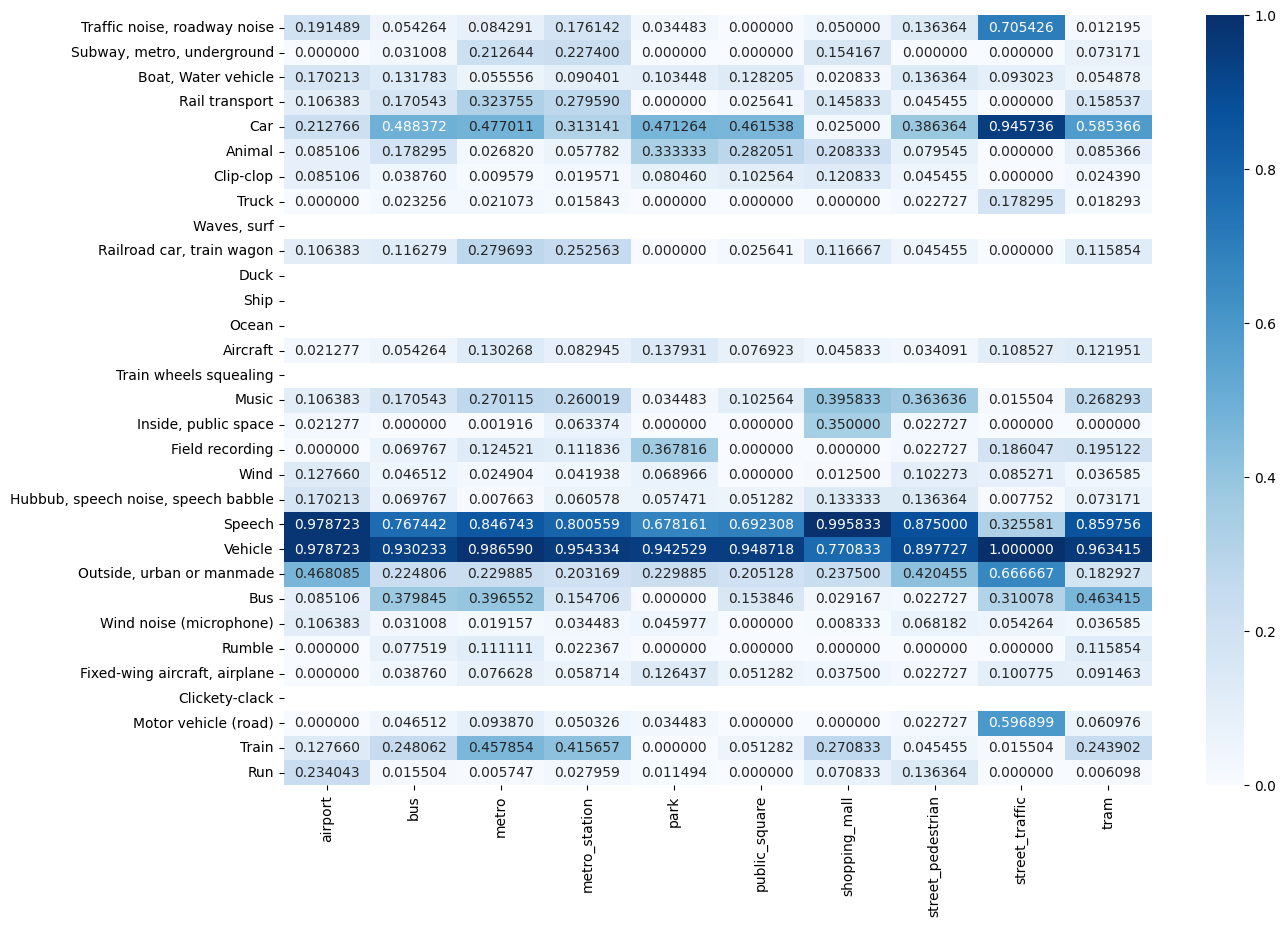

In [105]:
thresholded_correct_scene_tags_df = thresholded_correct_scene_tags_df.apply(pd.to_numeric)
plt.figure(figsize=(14,10))
sns.heatmap(thresholded_correct_scene_tags_df, fmt='f', annot=True, cmap='Blues')

<Axes: >

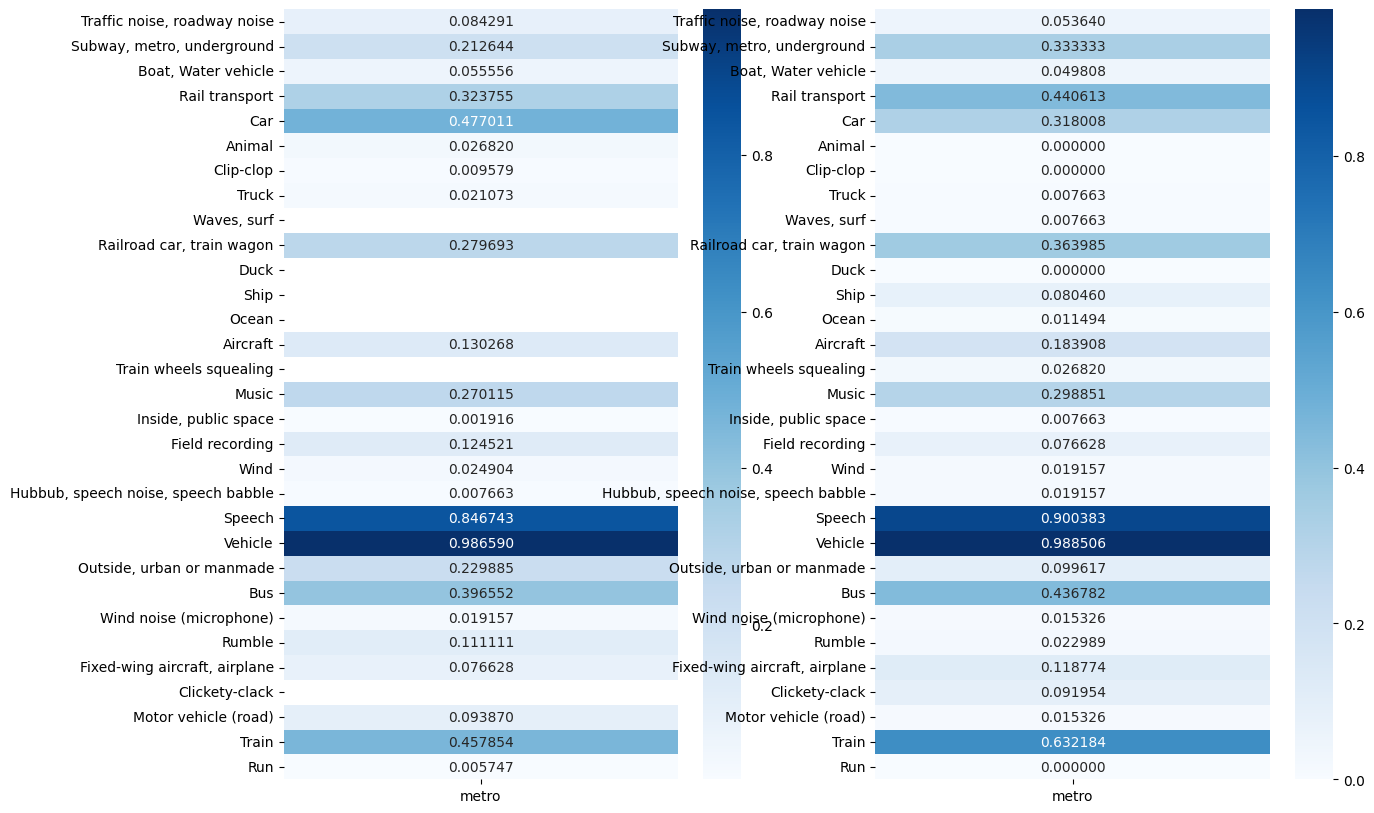

In [106]:
plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
sns.heatmap(thresholded_correct_scene_tags_df[['metro']], fmt='f', annot=True, cmap='Blues')
plt.subplot(1, 2, 2)
sns.heatmap(thresholded_scene_tag_counts_df[['metro']], fmt='f', annot=True, cmap='Blues')

<Axes: >

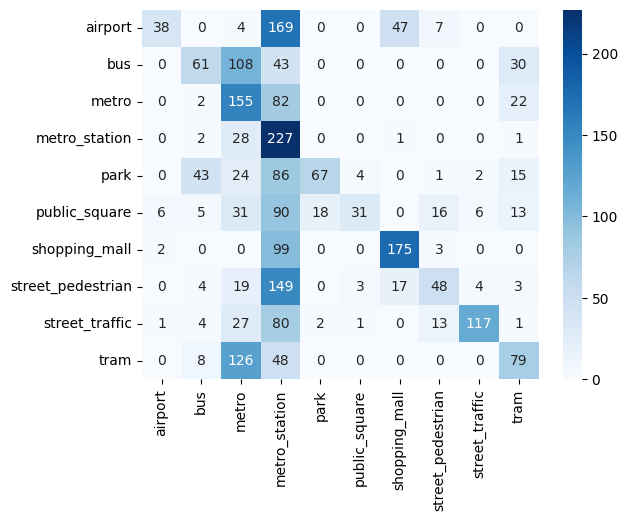

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['labels'], df['scene_preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=scenes, yticklabels=scenes)